In [1]:
import pandas as pd
import re
import glob
import os
from scipy import stats
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
from scipy.optimize import newton
from sklearn.metrics import auc
import math

In [2]:
colors = {
        "dark_purple": "#5F2E88",
        "purple": "#7E59A2",
        "light_purple": "#A17DB8",
        "pale_purple": "#dfd6e5",
        "dark_orange": "#F38227",
        "orange": "#E39943",
        "light_orange": "#EEBA7F",
        "pale_orange": "#f2d4b6",
        "dark_blue": "#3F60AC",
        "blue": "#7292C7",
        "light_blue": "#A5B3CC",
        "pale_blue": "#dae4f1",
        "dark_red": "#9C372F",
        "red": "#C76A6A",
        "light_red": "#E39C9D",
        "pale_red": "#edcccc",
        "dark_green": "#395A34",
        "green": "#688A2F",
        "light_green": "#B3CD86",
        "pale_green": "#d8e2c3",
        "dark_brown": "#764f2a",
        "brown": "#c2996c",
        "light_brown": "#e1bb96",
        "pale_brown": "#efccaf",
        "black": "#444147",
        "light_grey": "#EFEFEF",
        "light_gray": "#EFEFEF",
        "grey": "#6D6F72",
        "gray": "#6D6F72",
}

In [3]:
def truncated_mean(lam):
    mu=(1/lam-np.exp(-lam)*(1+1/lam))/(1-np.exp(-lam))
    return mu

def truncated_E_x2(lam):
    E_x2=(-(1/(1-np.exp(-lam))))*(np.exp(-lam)+((2*(np.exp(-lam)*(lam+1)-1))/(lam**2)))
    return E_x2

def truncated_var(lam):
    v=truncated_E_x2(lam)-(truncated_mean(lam)**2)
    return v

def equation(lam, given_mu):
    return truncated_mean(lam) - given_mu

def truncated_expo_cdf(x, lmbda):
    return (1 - np.exp(-lmbda * x)) / (1 - np.exp(-lmbda))

In [4]:
#Figure S3a
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
d2=dict((v, k) for k, v in d.items())

#read in all deep mutational files
path = '../Data/ProteinGym_substitutions/'
DMS_files=glob.glob(os.path.join(path, '*.csv'))

all_dms=[]
i=0
for f in DMS_files:
    dms=pd.read_csv(f)
    dms['mut_type']=dms['mutant'].str.replace(r'\d+', '', regex=True)
    dms['mut_type_len']=dms['mut_type'].str.len()
    dms=dms[dms['mut_type_len']==2]
    dms['fit_rank']=dms['DMS_score'].rank(pct=True)
    dms['pid']=i
    dms['size']=len(dms)
    dms['mut_type_count']=len(dms.mut_type.unique().tolist())
    all_dms.append(dms)
    i=i+1
all_dms=pd.concat(all_dms)
#pre-process data frame
AA_list=['ARG','LYS','GLN','GLU','ASP',
         'ASN','HIS','SER','THR','ALA',
         'VAL','ILE','LEU','MET','PRO',
         'GLY','TYR','PHE','TRP','CYS']
aa_list=[d[a] for a in AA_list]
all_dms['AA1']=all_dms['mut_type'].str[0]
all_dms['AA2']=all_dms['mut_type'].str[1]

mean_list=[]
var_list=[]
for i in range(20):
    for j in range(20):
        if i!=j:
            data = np.array(all_dms[(all_dms['AA1']==aa_list[i])&(all_dms['AA2']==aa_list[j])].fit_rank.tolist())
            mean_list.append(np.mean(data))
            var_list.append(np.var(data))
            
# Creating an array for lambda, avoiding 0.
lambdas_p = np.linspace(0.1,6,100)
lambdas_n = np.linspace(-6,0.1,100)
lambdas=np.concatenate((lambdas_n, lambdas_p), axis=None)

E_X = truncated_mean(lambdas)
Var_X =truncated_var(lambdas)


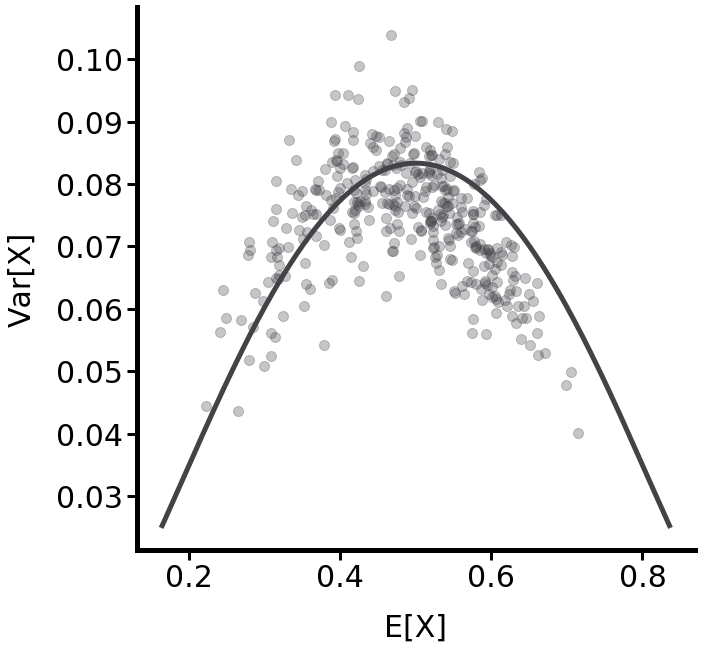

In [5]:
plt.figure(figsize=(10, 10))
plt.plot(E_X, Var_X,color=colors['black'],linewidth=5)
plt.scatter(mean_list,var_list,color=colors['black'],s=100,alpha=0.3)
plt.xlabel('E[X]',fontsize=30,labelpad=20)
plt.ylabel('Var[X]',fontsize=30,labelpad=20)
plt.xticks(fontsize=30)        # Adjust tick label size
plt.yticks(fontsize=30)
#plt.legend()
plt.grid(False)
#plt.gca().set_facecolor(colors['light_gray'])
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(5)  # Thicker y-axis
ax.spines['bottom'].set_linewidth(5)  # Thicker x-axis
# Make ticks thicker, longer, and pointing inward
ax.tick_params(axis='both', direction='out', length=10, width=3, labelsize=30)
plt.show()

In [6]:
#Figure S3b
#read in all deep mutational files
np.random.seed(0)
path = '../Data/ProteinGym_substitutions/'
DMS_files=glob.glob(os.path.join(path, '*.csv'))
all_dms=[]
i=0
for f in DMS_files:
    dms=pd.read_csv(f)
    dms['mut_type']=dms['mutant'].str.replace(r'\d+', '', regex=True)
    dms['mut_type_len']=dms['mut_type'].str.len()
    dms=dms[dms['mut_type_len']==2]
    dms['split']=np.random.choice(['train','test'],size=len(dms))
    dms['fit_rank']=dms.groupby('split')['DMS_score'].rank(pct=True)
    dms['pid']=i
    dms['size']=len(dms)
    dms['mut_type_count']=len(dms.mut_type.unique().tolist())
    all_dms.append(dms)
    i=i+1
all_dms=pd.concat(all_dms)

In [7]:
#look at all pairs
np.random.seed(0)
AA_pairs=all_dms.mut_type.unique().tolist()
pid_for_test=all_dms[all_dms['mut_type_count']==380].pid.unique().tolist()
D=[]
p=[]
sample_size=[]
mu=[]
lmbda=[]
for ap in AA_pairs:
    data = all_dms[all_dms['mut_type']==ap]
    data_train=np.array(data[data['split']=='train'].fit_rank.tolist())
    data_test=np.array(data[data['split']=='test'].fit_rank.tolist())
    sample_size.append(len(data_test))
    given_mu=np.mean(data_train)
    mu.append(given_mu)
    # Extract the lambda parameter that maximizes the likelihood
    lmbda_opt = newton(equation, 1, args=(given_mu,))
    lmbda.append(lmbda_opt)
    Di,pi=stats.kstest(data_test, truncated_expo_cdf, args=(lmbda_opt,))
    D.append(Di)
    p.append(pi)

In [8]:
df_MLEfit_plot=pd.DataFrame({'mut_type':AA_pairs,
                              'D':D,
                              'p':p,
                             'sample_size':sample_size,
                             'mu':mu,
                             'lmbda':lmbda})

df_MLEfit_plot['Bonferroni_p']=df_MLEfit_plot['p']*380

In [9]:
1-sum(df_MLEfit_plot['Bonferroni_p']<0.05)/380

0.9657894736842105

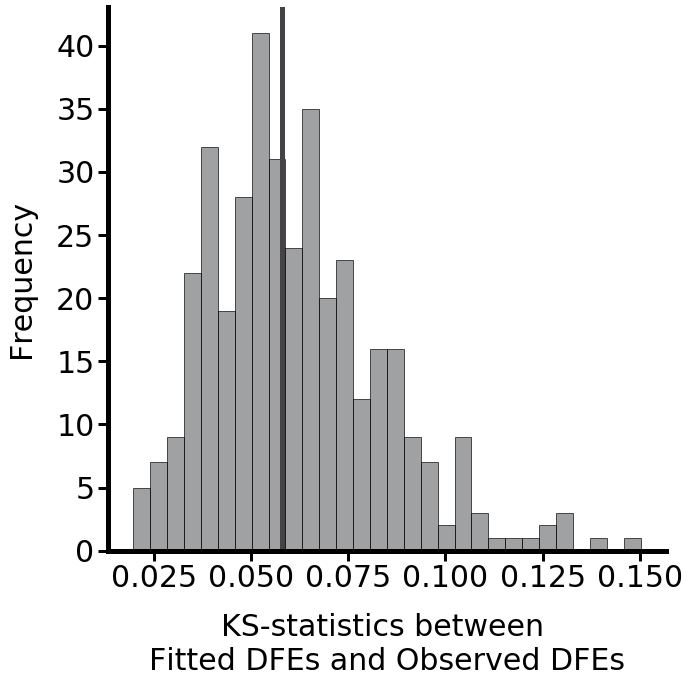

In [10]:
plt.figure(figsize=(10, 10), facecolor='white')  # Adjust size and background color
result = plt.hist(D, bins=30, color=colors['gray'], edgecolor='k', alpha=0.65)
plt.axvline(np.median(D), color=colors['black'], linestyle='solid', linewidth=5)
plt.xlabel('KS-statistics between \nFitted DFEs and Observed DFEs',fontsize=30,labelpad=20)  # X-axis label
plt.ylabel('Frequency',fontsize=30,labelpad=20)        # Y-axis label
plt.xticks(fontsize=30)        # Adjust tick label size
plt.yticks(fontsize=30)
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(5)  # Thicker y-axis
ax.spines['bottom'].set_linewidth(5)  # Thicker x-axis
# Make ticks thicker, longer, and pointing inward
ax.tick_params(axis='both',length=10, width=3, labelsize=30)

In [11]:
#Figure S3c

In [12]:
#filter by mut type count
all_dms_adjust=all_dms[all_dms['mut_type_count']==380]
#up-sampling
np.random.seed(0)
plist=all_dms_adjust.pid.unique().tolist()
all_dms_upsample=[]
for p in plist:
    all_dms_tmp=all_dms_adjust[all_dms_adjust['pid']==p]
    mut2count=all_dms_tmp.groupby('mut_type').agg(sample_size=('pid','size')).reset_index()
    max_count=mut2count.sample_size.max()
    dms_upsam_p=[]
    for m in mut2count.mut_type.tolist():
        upsam=np.array(all_dms_tmp[all_dms_tmp['mut_type']==m].DMS_score.tolist())
        upsam=np.random.choice(upsam,max_count).tolist()
        df_upsam_m=pd.DataFrame({'DMS_score':upsam})
        df_upsam_m['mut_type']=m
        dms_upsam_p.append(df_upsam_m)
    df_upsam_p=pd.concat(dms_upsam_p)
    df_upsam_p['pid']=p
    df_upsam_p['fit_rank']=df_upsam_p['DMS_score'].rank(pct=True)
    all_dms_upsample.append(df_upsam_p)
all_dms_upsample=pd.concat(all_dms_upsample)

#look at all pairs
np.random.seed(0)
AA_pairs=all_dms_upsample.mut_type.unique().tolist()
sample_size=[]
D=[]
p=[]
lambda_list=[]
mu_list=[]
for ap in AA_pairs:
    data = all_dms_upsample[all_dms_upsample['mut_type']==ap].fit_rank.tolist()
    sample_size.append(len(data))
    data = np.array(data)
    given_mu=np.mean(data)
    mu_list.append(given_mu)
    # Extract the lambda parameter that maximizes the likelihood
    lmbda_opt=newton(equation, 1, args=(given_mu,))
    lambda_list.append(lmbda_opt)
    Di,pi=stats.kstest(data, truncated_expo_cdf, args=(lmbda_opt,))
    D.append(Di)
    p.append(pi)

df_upsampling_fit=pd.DataFrame({'mut_type':AA_pairs,
                                'lmbda':lambda_list,
                                'mu':mu_list,
                                'sample_size':sample_size,
                                'D':D,
                                'p':p})

df_fit_compare=df_MLEfit_plot[['mut_type','lmbda','mu']]
df_fit_compare=df_fit_compare.rename(columns={'lmbda':'lmbda_raw',
                                              'mu':'mu_raw'})
df_fit_compare=df_fit_compare.merge(df_upsampling_fit[['mut_type','lmbda','mu']],
                                    how='inner',on='mut_type')

In [13]:
stats.spearmanr(df_fit_compare['lmbda_raw'].tolist(),
                df_fit_compare['lmbda'].tolist())

SpearmanrResult(correlation=0.9857023357429577, pvalue=1.862105793600112e-294)

In [14]:
stats.pearsonr(df_fit_compare['lmbda_raw'].tolist(),
               df_fit_compare['lmbda'].tolist())

(0.9856659834397814, 2.9988046421963475e-294)

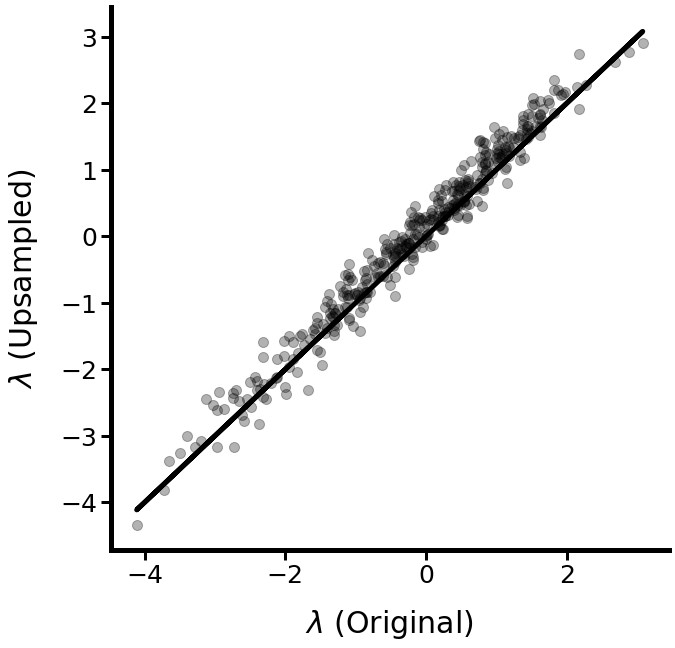

In [15]:
# Create the scatter plot using DataFrame columns directly
plt.figure(figsize=(10, 10), facecolor='white')
plt.scatter(-df_fit_compare['lmbda_raw'], -df_fit_compare['lmbda'], color='black',alpha=0.3,s=100)

# Draw a horizontal line at y=0.15
plt.plot(-df_fit_compare['lmbda_raw'], -df_fit_compare['lmbda_raw'], color='black', linestyle='-',linewidth=5) 

# Setting the title and labels
#plt.title('Scatter plot of original fit versus upsampled fit')
plt.xlabel(r'$\lambda$ (Original)',fontsize=30,labelpad=20)
plt.ylabel(r'$\lambda$ (Upsampled)',fontsize=30,labelpad=20)
plt.xticks(fontsize=25)        # Adjust tick label size
plt.yticks(fontsize=24)
#plt.gca().set_facecolor(colors['light_gray'])
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(5)  # Thicker y-axis
ax.spines['bottom'].set_linewidth(5)  # Thicker x-axis
# Make ticks thicker, longer, and pointing inward
ax.tick_params(axis='both', direction='out', length=10, width=3, labelsize=25)
#plt.legend()
# Display the plot
plt.show()

In [16]:
#Figure S3d

In [17]:
np.random.seed(0)
plist=all_dms_adjust.pid.unique().tolist()
all_dms_sample=[]
for p in plist:
    all_dms_tmp=all_dms_adjust[all_dms_adjust['pid']==p]
    mut2count=all_dms_tmp.groupby('mut_type').agg(sample_size=('pid','size')).reset_index()
    sample_count=mut2count.sample_size.min()
    dms_sam_p=[]
    for m in mut2count.mut_type.tolist():
        sam=np.array(all_dms_tmp[all_dms_tmp['mut_type']==m].DMS_score.tolist())
        sam=np.random.choice(sam,sample_count).tolist()
        df_sam_m=pd.DataFrame({'DMS_score':sam})
        df_sam_m['mut_type']=m
        dms_sam_p.append(df_sam_m)
    df_sam_p=pd.concat(dms_sam_p)
    df_sam_p['pid']=p
    df_sam_p['fit_rank']=df_sam_p['DMS_score'].rank(pct=True)
    all_dms_sample.append(df_sam_p)
all_dms_sample=pd.concat(all_dms_sample)

#look at all pairs
np.random.seed(0)
AA_pairs=all_dms_sample.mut_type.unique().tolist()
sample_size=[]
D=[]
p=[]
lambda_list=[]
mu_list=[]
for ap in AA_pairs:
    data = all_dms_sample[all_dms_sample['mut_type']==ap].fit_rank.tolist()
    sample_size.append(len(data))
    data = np.array(data)
    given_mu=np.mean(data)
    mu_list.append(given_mu)
    # Extract the lambda parameter that maximizes the likelihood
    lmbda_opt=newton(equation, 1, args=(given_mu,))
    lambda_list.append(lmbda_opt)
    Di,pi=stats.kstest(data, truncated_expo_cdf, args=(lmbda_opt,))
    D.append(Di)
    p.append(pi)

df_sampling_fit=pd.DataFrame({'mut_type':AA_pairs,
                              'lmbda':lambda_list,
                              'mu':mu_list,
                              'sample_size':sample_size,
                              'D':D,
                              'p':p})

df_fit_compare=df_MLEfit_plot[['mut_type','lmbda','mu']]
df_fit_compare=df_fit_compare.rename(columns={'lmbda':'lmbda_raw',
                                              'mu':'mu_raw'})
df_fit_compare=df_fit_compare.merge(df_sampling_fit[['mut_type','lmbda','mu']],
                                    how='inner',on='mut_type')

In [18]:
stats.spearmanr(df_fit_compare['lmbda_raw'].tolist(),
                df_fit_compare['lmbda'].tolist())

SpearmanrResult(correlation=0.9535134555896108, pvalue=5.279828680249087e-199)

In [19]:
stats.pearsonr(df_fit_compare['lmbda_raw'].tolist(),
               df_fit_compare['lmbda'].tolist())

(0.9554584976211025, 1.9730175246708308e-202)

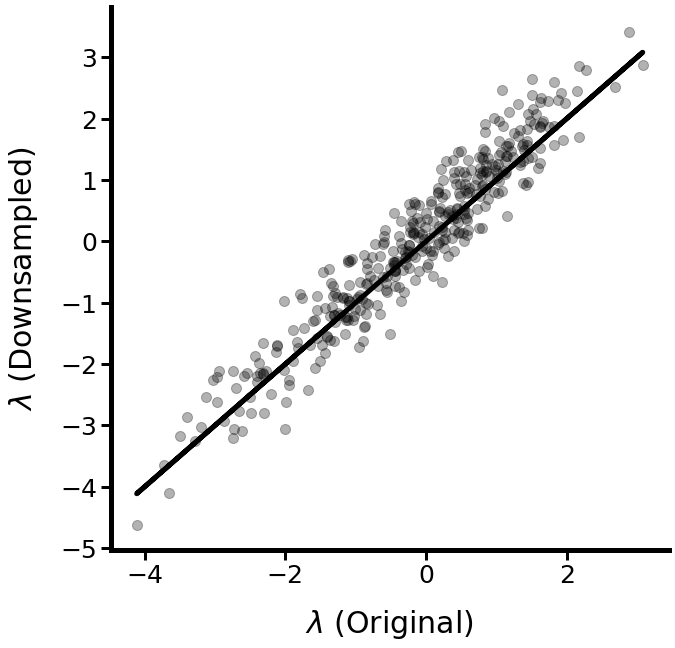

In [20]:
# Create the scatter plot using DataFrame columns directly
plt.figure(figsize=(10, 10), facecolor='white')
plt.scatter(-df_fit_compare['lmbda_raw'], -df_fit_compare['lmbda'], color='black',alpha=0.3,s=100)

# Draw a horizontal line at y=0.15
plt.plot(-df_fit_compare['lmbda_raw'], -df_fit_compare['lmbda_raw'], color='black', linestyle='-',linewidth=5) 

# Setting the title and labels
#plt.title('Scatter plot of original fit versus upsampled fit')
plt.xlabel(r'$\lambda$ (Original)',fontsize=30,labelpad=20)
plt.ylabel(r'$\lambda$ (Downsampled)',fontsize=30,labelpad=20)
plt.xticks(fontsize=25)        # Adjust tick label size
plt.yticks(fontsize=25)
#plt.gca().set_facecolor(colors['light_gray'])
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(5)  # Thicker y-axis
ax.spines['bottom'].set_linewidth(5)  # Thicker x-axis
#plt.legend()
# Make ticks thicker, longer, and pointing inward
ax.tick_params(axis='both', direction='out', length=10, width=3, labelsize=25)
# Display the plot
plt.show()